In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr8k-sau:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F122238%2F294885%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T135314Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da09600f59664f2b09dda7601a4db9e1d3a2e0da067d08e977dbe845f9a42ab37b4a997cb16c2d8172f22865b3ea6cf70d5afb632c1be9c9c495ca6d65c0466681fe96dd8f68ca1639387e93120888007119c9d03d03a4974683ea9181652297db7615aafc0ac7cbb6d22c4012405981cc3579ecd93215e3f75037d1876477776983054376f7d9480378bc05980bba4af453c96a2d5d5101f107c6cfccf71a9227aa53d8ef5650b59805676a2062a0376aed564ef5e35c9241b44d71462d1bc345cda89eab69974f7e95e69bdcc3904c451c2bf327a815973d3fd7b780c829c5a38c40e905f3ac5ce1ec33c865ce2dd05f43118095fff78efd8cdc2dc5dbada79'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2229559744 bytes downloaded
Downloaded and uncompressed: flickr8k-sau
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob

# **image Preprocess**

In [ ]:
images_path = '../input/flickr8k-sau/Flickr_Data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

In [ ]:
images[:5]

['../input/flickr8k-sau/Flickr_Data/Images/3585495069_33cba06d0a.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/3522749949_fb615cee47.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/3064716525_b8418d4946.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/2616009069_82561da2e5.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/3373069977_bc73e9e409.jpg']

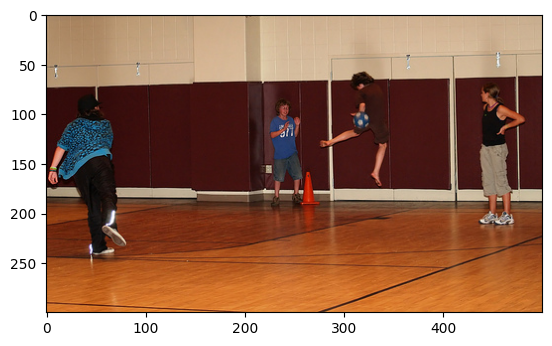

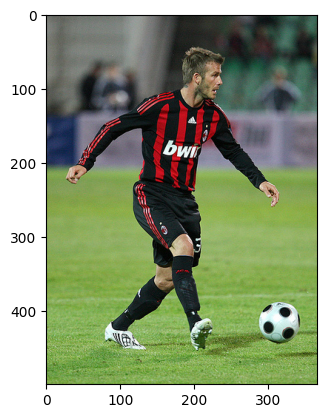

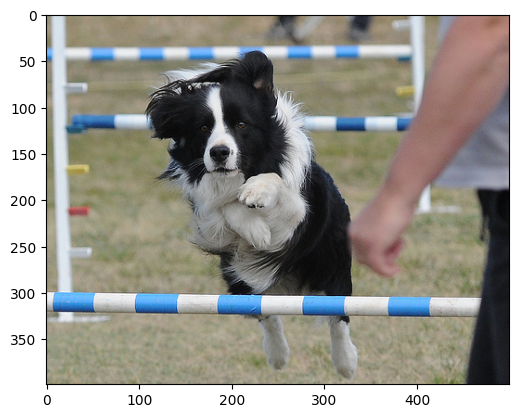

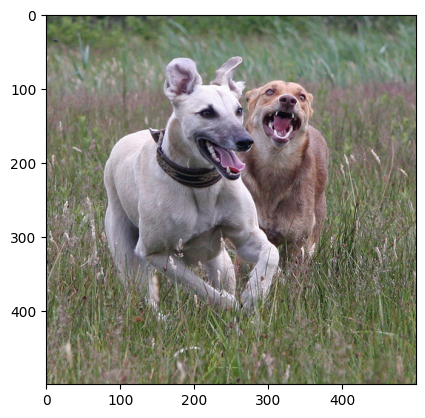

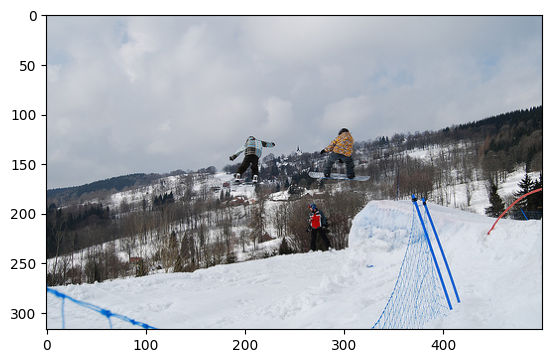

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [ ]:
from keras.applications import ResNet50

incept_model = ResNet50(include_top=True)

102967424/102967424 [==============================] - 5s 0us/step


In [ ]:
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))

    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)

    img_name = i.split('/')[-1]

    images_features[img_name] = pred

    count += 1

    if count > 1499:
        break

    elif count % 50 == 0:
        print(count)




1/1 [==============================] - 0s 20ms/step
50
1/1 [==============================] - 0s 34ms/step
100
1/1 [==============================] - 0s 22ms/step
150
1/1 [==============================] - 0s 21ms/step
200
1/1 [==============================] - 0s 33ms/step
250
1/1 [==============================] - 0s 21ms/step
300
1/1 [==============================] - 0s 20ms/step
350
1/1 [==============================] - 0s 20ms/step
400
1/1 [==============================] - 0s 20ms/step
450
1/1 [==============================] - 0s 21ms/step
500
1/1 [==============================] - 0s 21ms/step
550
1/1 [==============================] - 0s 21ms/step
600
1/1 [==============================] - 0s 38ms/step
650
1/1 [==============================] - 0s 21ms/step
700
1/1 [==============================] - 0s 21ms/step
750
1/1 [==============================] - 0s 25ms/step
800
1/1 [==============================] - 0s 21ms/step
850
1/1 [==============================] - 0s 23ms/st

In [ ]:
len(images_features)

1500

# **Text Preprocess**

In [ ]:
caption_path = '../input/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [ ]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [ ]:
len(captions)

40461

In [ ]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2]
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]

            else:
                captions_dict[img_name].append(caption)

    except:
        pass

In [ ]:
len(captions_dict)

1500

# **Visualize Images with captions**

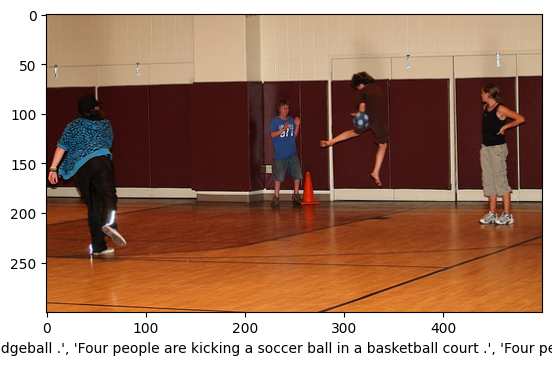

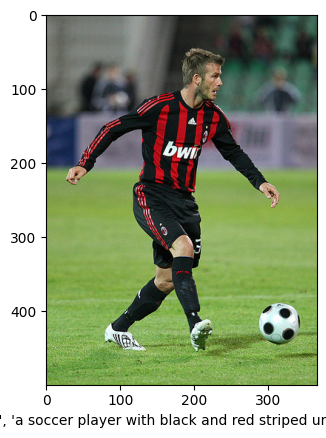

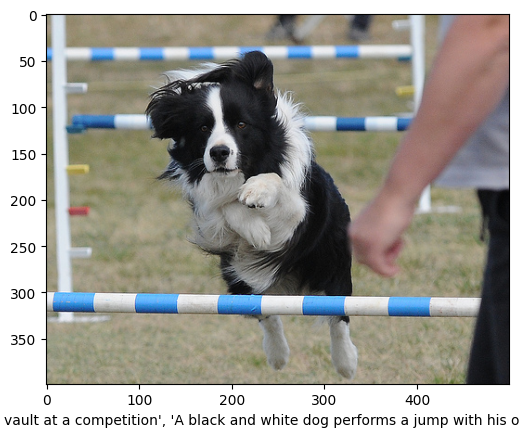

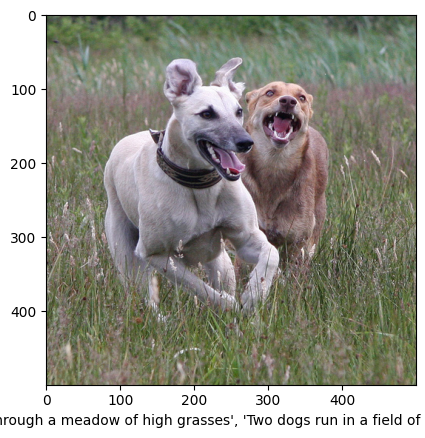

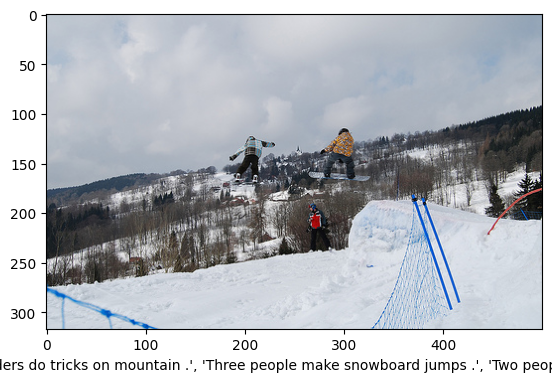

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]


    img = cv2.imread(img_name)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

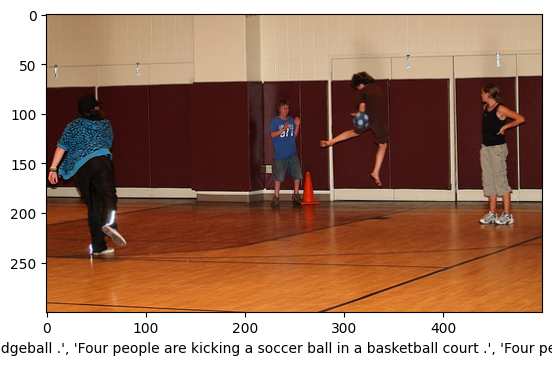

In [ ]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()

    img_name = '../input/flickr8k-sau/Flickr_Data/Images/' + k


    img = cv2.imread(img_name)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

    break

In [ ]:

def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified


In [ ]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

# **Create Vocabulary**

In [ ]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [ ]:
len(count_words)

3984

In [ ]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1


In [ ]:
len(new_dict)

3984

In [ ]:
new_dict['<OUT>'] = len(new_dict)

In [ ]:
captions_backup = captions_dict.copy()

In [ ]:
captions_dict = captions_backup.copy()

In [ ]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

In [ ]:
captions_dict

{'1000268201_693b08cb0e.jpg': [[1,
   2,
   3,
   4,
   2,
   5,
   6,
   7,
   8,
   9,
   2,
   10,
   11,
   12,
   4,
   13,
   14,
   15,
   16,
   17],
  [1, 2, 18, 19, 20, 2, 21, 22, 16, 17],
  [1, 2, 23, 18, 8, 20, 2, 21, 24, 16, 17],
  [1, 2, 23, 18, 8, 25, 12, 26, 27, 24, 16, 17],
  [1, 2, 23, 18, 4, 2, 5, 6, 19, 20, 2, 21, 28, 16, 17]],
 '1002674143_1b742ab4b8.jpg': [[1,
   2,
   23,
   18,
   29,
   4,
   30,
   31,
   4,
   32,
   11,
   2,
   33,
   34,
   35,
   27,
   36,
   4,
   2,
   37,
   16,
   17],
  [1, 2, 23, 18, 7, 38, 4, 32, 11, 2, 39, 33, 34, 16, 17],
  [1,
   2,
   40,
   18,
   4,
   25,
   41,
   42,
   35,
   43,
   4,
   32,
   11,
   2,
   44,
   45,
   35,
   2,
   34,
   46,
   47,
   16,
   17],
  [1, 48, 7, 2, 18, 35, 49, 38, 4, 32, 11, 2, 34, 50, 16, 17],
  [1, 51, 18, 35, 49, 50, 52, 4, 25, 41, 16, 17]],
 '1015118661_980735411b.jpg': [[1,
   2,
   53,
   54,
   4,
   32,
   11,
   2,
   55,
   56,
   4,
   2,
   57,
   16,
   17],
  [1,
   2,
   

------------------------------------------------------------------------------------------------------

# **Build Generator Function**

In [ ]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 2, 5, 6, 7, 8, 9, 2, 10, 11, 12, 4, 13, 14, 15, 16, 17]
[1, 2, 23, 18, 29, 4, 30, 31, 4, 32, 11, 2, 33, 34, 35, 27, 36, 4, 2, 37, 16, 17]
[1, 2, 40, 18, 4, 25, 41, 42, 35, 43, 4, 32, 11, 2, 44, 45, 35, 2, 34, 46, 47, 16, 17]
[1, 2, 61, 146, 46, 2, 147, 4, 2, 140, 141, 148, 2, 79, 149, 71, 2, 150, 151, 35, 13, 152, 153, 16, 17]
[1, 2, 61, 4, 82, 200, 2, 23, 53, 9, 4, 25, 203, 71, 207, 208, 73, 26, 209, 139, 210, 211, 212, 206, 73, 16, 17]
[1, 2, 61, 7, 58, 35, 115, 374, 375, 363, 168, 364, 60, 25, 296, 72, 73, 7, 125, 196, 161, 11, 25, 127, 376, 4, 25, 377, 16, 17]
[1, 2, 220, 4, 13, 280, 461, 71, 77, 7, 879, 46, 2, 78, 56, 60, 2, 674, 220, 4, 2, 433, 299, 241, 223, 26, 27, 46, 25, 56, 880, 27, 587, 588, 17]
[1, 60, 161, 44, 80, 7, 52, 25, 183, 215, 117, 44, 80, 35, 2, 156, 1279, 46, 273, 328, 7, 125, 20, 2, 444, 184, 183, 60, 845, 277, 134, 2, 89, 86, 16, 17]


In [ ]:
MAX_LEN

36

In [ ]:
captions_dict

{'1000268201_693b08cb0e.jpg': [[1,
   2,
   3,
   4,
   2,
   5,
   6,
   7,
   8,
   9,
   2,
   10,
   11,
   12,
   4,
   13,
   14,
   15,
   16,
   17],
  [1, 2, 18, 19, 20, 2, 21, 22, 16, 17],
  [1, 2, 23, 18, 8, 20, 2, 21, 24, 16, 17],
  [1, 2, 23, 18, 8, 25, 12, 26, 27, 24, 16, 17],
  [1, 2, 23, 18, 4, 2, 5, 6, 19, 20, 2, 21, 28, 16, 17]],
 '1002674143_1b742ab4b8.jpg': [[1,
   2,
   23,
   18,
   29,
   4,
   30,
   31,
   4,
   32,
   11,
   2,
   33,
   34,
   35,
   27,
   36,
   4,
   2,
   37,
   16,
   17],
  [1, 2, 23, 18, 7, 38, 4, 32, 11, 2, 39, 33, 34, 16, 17],
  [1,
   2,
   40,
   18,
   4,
   25,
   41,
   42,
   35,
   43,
   4,
   32,
   11,
   2,
   44,
   45,
   35,
   2,
   34,
   46,
   47,
   16,
   17],
  [1, 48, 7, 2, 18, 35, 49, 38, 4, 32, 11, 2, 34, 50, 16, 17],
  [1, 51, 18, 35, 49, 50, 52, 4, 25, 41, 16, 17]],
 '1015118661_980735411b.jpg': [[1,
   2,
   53,
   54,
   4,
   32,
   11,
   2,
   55,
   56,
   4,
   2,
   57,
   16,
   17],
  [1,
   2,
   

In [ ]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0

    X = []
    y_in = []
    y_out = []

    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)

    return X, y_in, y_out



In [ ]:
X, y_in, y_out = generator(images_features, captions_dict)

In [ ]:
len(X), len(y_in), len(y_out)

(96389, 96389, 96389)

In [ ]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')



In [ ]:
X.shape, y_in.shape, y_out.shape

((96389, 2048), (96389, 36), (96389, 3985))

In [ ]:
X[1510]

array([0.02809042, 1.139322  , 0.2907029 , ..., 0.        , 0.42163554,
       0.        ], dtype=float32)

In [ ]:
y_in[2]

array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

# **MODEL**

In [ ]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [ ]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVecto  (None, 36, 128)           0         
 r)                                                              
                                                                 
Total params: 262272 (1.00 MB)
Trainable params: 262272 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 128)           510080    
                                                                 
 lstm (LSTM)                 (None, 36, 256)           394240   

In [ ]:
model.fit([X, y_in], y_out, batch_size=512, epochs=50)

Epoch 1/50
189/189 [==============================] - 24s 92ms/step - loss: 5.3355 - accuracy: 0.1194
Epoch 2/50
189/189 [==============================] - 16s 83ms/step - loss: 5.1579 - accuracy: 0.1223
Epoch 3/50
189/189 [==============================] - 16s 83ms/step - loss: 5.0793 - accuracy: 0.1225
Epoch 4/50
189/189 [==============================] - 16s 83ms/step - loss: 4.9999 - accuracy: 0.1226
Epoch 5/50
189/189 [==============================] - 16s 82ms/step - loss: 4.9352 - accuracy: 0.1227
Epoch 6/50
189/189 [==============================] - 16s 82ms/step - loss: 4.8780 - accuracy: 0.1226
Epoch 7/50
189/189 [==============================] - 15s 82ms/step - loss: 4.8305 - accuracy: 0.1222
Epoch 8/50
189/189 [==============================] - 15s 82ms/step - loss: 4.7889 - accuracy: 0.1228
Epoch 9/50
189/189 [==============================] - 15s 82ms/step - loss: 4.7492 - accuracy: 0.1221
Epoch 10/50
189/189 [==============================] - 15s 81ms/step - loss: 4.709

In [ ]:
inv_dict = {v:k for k, v in new_dict.items()}

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save_weights('mine_model_weights.h5')

In [ ]:
np.save('vocab.npy', new_dict)

In [ ]:
def getImage(x):

    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (299,299))

    test_img = np.reshape(test_img, (1,299,299,3))

    return test_img

# **Predictions**

1/1 [==============================] - 0s 28ms/step


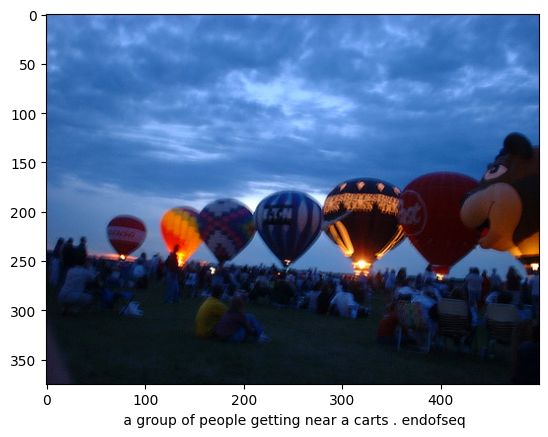

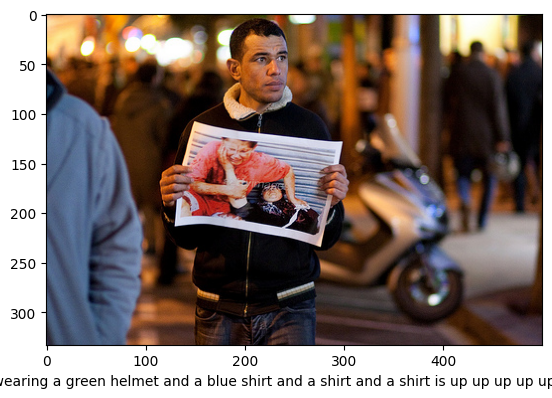

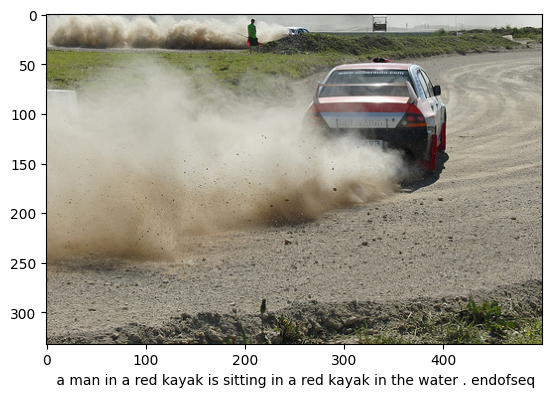

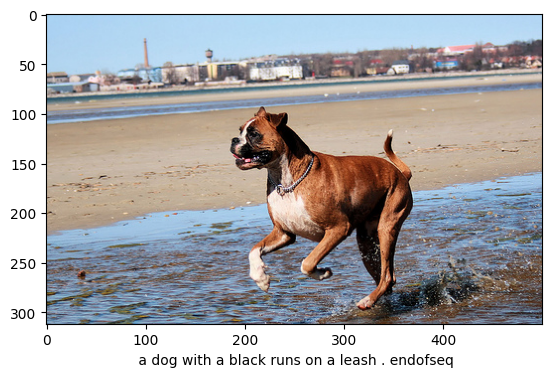

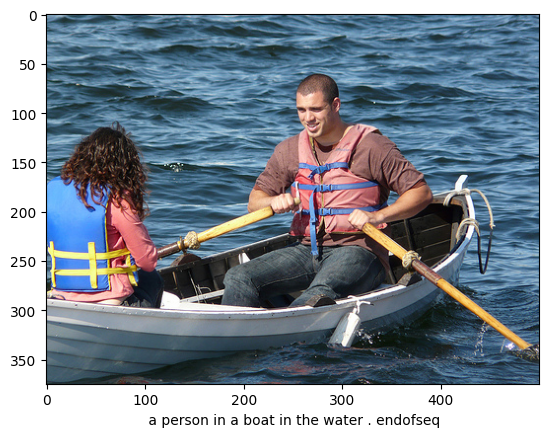

In [ ]:
for i in range(5):

    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)

    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word

        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)

    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

def preprocess_image(image_path):
    test_img = cv2.imread(image_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img, (299, 299))
    test_img = np.reshape(test_img, (1, 299, 299, 3))
    return test_img

def generate_caption(image_path, model, tokenizer, new_dict, inv_dict, max_len):
    test_feature = model.predict(preprocess_image(image_path)).reshape(1, 2048)

    text_inp = ['startofseq']
    count = 0
    caption = ''
    while count < 25:
        count += 1
        encoded = []
        for word in text_inp:
            encoded.append(new_dict[word])

        encoded = [encoded]
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len)
        prediction = np.argmax(model.predict([test_feature, encoded]))
        sampled_word = inv_dict[prediction]
        caption = caption + ' ' + sampled_word
        if sampled_word == 'endofseq':
            break
        text_inp.append(sampled_word)

    return caption.strip()

# Example usage
model = modele  # Replace your_model with your trained model
#tokenizer =   # Replace your_tokenizer with your tokenizer

image_path = input("Enter the path to the image: ")
caption = generate_caption(image_path, model, tokenizer, new_dict, inv_dict, MAX_LEN)
print("Predicted caption:", caption)

# Display the image with the predicted caption
test_img = cv2.imread(image_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(test_img)
plt.xlabel(caption)
plt.show()


NotADirectoryError: [Errno 20] Not a directory: '/input/flickr8k-sau/Flickr_Data/Images/1000268201_693b08cb0e.jpg'